In [496]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ML
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split, StratifiedKFold
# StratifiedKFold
skf = StratifiedKFold(
    n_splits=10,
    shuffle=True,
    random_state=42
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,classification_report, precision_recall_curve, auc

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Imbalance
from imblearn.over_sampling import SMOTE

# Metrics
from sklearn.metrics import (
    roc_auc_score,
    recall_score,
    precision_recall_curve,
    auc,
    classification_report
)

# Explainability
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer

In [497]:
df = pd.read_csv("Dataset-Imbalance/medication_adherence.csv")

In [498]:
df.head(10)

,patient_id,age,gender,chronic_condition,medication_type,dosage,comorbidities,BMI,event_id,timestamp,...,blood_pressure,blood_glucose,activity_level,sleep_hours,stress_level,reminder_sent,reminder_response_time,social_support,location,future_non_adherence
0,P0103,45,M,diabetes,Metformin,50,0,24.8,E00000,2025-05-22 02:46:32,...,139/81,170.2,8030,5.2,3,1,15.0,0,work,0
1,P0436,79,M,hypertension,Metformin,500,0,25.2,E00001,2025-03-02 22:26:25,...,123/82,80.1,5338,8.8,2,1,94.0,0,home,0
2,P0861,71,F,diabetes,Salbutamol,20,3,28.6,E00002,2025-09-13 02:37:54,...,138/80,110.1,9021,5.6,4,1,86.0,2,hospital,0
3,P0271,89,M,hypertension,Atorvastatin,10,0,22.9,E00003,2025-01-26 03:54:55,...,122/84,157.2,4930,4.8,4,1,100.0,4,hospital,0
4,P0107,84,F,diabetes,Amlodipine,10,3,34.5,E00004,2025-02-20 03:28:37,...,125/79,147.3,5960,7.6,3,0,NaN,2,hospital,0
5,P0072,37,F,asthma,Salbutamol,500,1,28.3,E00005,2025-06-08 09:37:44,...,132/79,72.9,3220,8.1,4,0,NaN,1,home,1
6,P0701,79,M,hypertension,Atorvastatin,5,3,24.8,E00006,2025-09-15 03:36:56,...,124/78,119.5,2439,5.6,4,1,64.0,0,hospital,0
7,P0021,50,M,hypertension,Metformin,500,0,29.0,E00007,2025-08-05 11:59:02,...,112/72,161.2,7246,5.4,3,0,NaN,3,work,1
8,P0615,30,F,cardiovascular,Salbutamol,5,1,24.7,E00008,2025-02-28 19:08:36,...,115/85,151.1,8424,5.2,1,0,NaN,3,hospital,1
9,P0122,84,F,cardiovascular,Metformin,5,2,31.9,E00009,2025-02-11 02:23:00,...,118/81,115.3,9905,6.0,3,0,NaN,3,work,0


In [499]:
TARGET = "future_non_adherence"

DROP_COLS = [
    "patient_id",
    "event_id"
]


In [500]:
df["timestamp"] = pd.to_datetime(df["timestamp"])

df["hour"] = df["timestamp"].dt.hour
df["dayofweek"] = df["timestamp"].dt.dayofweek


In [501]:
df[["bp_systolic", "bp_diastolic"]] = (
    df["blood_pressure"]
    .str.split("/", expand=True)
    .astype(float)
)


In [502]:
df["reminder_response_time"] = df["reminder_response_time"].fillna(-1)


In [503]:
X = df.drop(columns=DROP_COLS + [TARGET, "timestamp", "blood_pressure"])
y = df[TARGET]


In [504]:
categorical_features = [
    "gender",
    "chronic_condition",
    "medication_type",
    "location"
]

numerical_features = [
    "age", "dosage", "BMI",
    "activity_level", "sleep_hours", "stress_level",
    "blood_glucose",
    "bp_systolic", "bp_diastolic",
    "reminder_sent", "reminder_response_time",
    "social_support",
    "hour", "dayofweek"
]


In [505]:
df_sorted = df.sort_values("timestamp")

split_index = int(0.8 * len(df_sorted))

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]


In [506]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numerical_features)
    ]
)


In [507]:
models = {
    "LightGBM": LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        class_weight="balanced",
        random_state=42
    ),

    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
        eval_metric="logloss",
        random_state=42
    ),

    "CatBoost": CatBoostClassifier(
        iterations=300,
        learning_rate=0.05,
        depth=6,
        loss_function="Logloss",
        auto_class_weights="Balanced",
        verbose=False,
        random_seed=42
    ),

    "DecisionTree": DecisionTreeClassifier(
        max_depth=6,
        min_samples_leaf=50,
        class_weight="balanced",
        random_state=42
    ),

    "RandomForest": RandomForestClassifier(
        n_estimators=300,
        max_depth=8,
        min_samples_leaf=30,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    ),
}


In [508]:
cv_results = []

for name, model in models.items():
    roc_auc_scores = []
    recall_scores = []
    pr_auc_scores = []

    for train_idx, val_idx in skf.split(X, y):
        X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
        y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

        pipeline = Pipeline(
            steps=[
                ("preprocess", preprocessor),
                ("model", model)
            ]
        )

        pipeline.fit(X_train_cv, y_train_cv)

        y_proba = pipeline.predict_proba(X_val_cv)[:, 1]
        y_pred  = (y_proba >= 0.5).astype(int)

        # Metrics
        roc_auc_scores.append(
            roc_auc_score(y_val_cv, y_proba)
        )

        recall_scores.append(
            recall_score(y_val_cv, y_pred)
        )

        precision, recall_curve, _ = precision_recall_curve(
            y_val_cv, y_proba
        )
        pr_auc_scores.append(
            auc(recall_curve, precision)
        )

    cv_results.append({
        "Model": name,
        "ROC_AUC_mean": np.mean(roc_auc_scores),
        "ROC_AUC_std": np.std(roc_auc_scores),
        "Recall_mean": np.mean(recall_scores),
        "Recall_std": np.std(recall_scores),
        "PR_AUC_mean": np.mean(pr_auc_scores),
        "PR_AUC_std": np.std(pr_auc_scores)
    })
cv_results_df = pd.DataFrame(cv_results)

[LightGBM] [Info] Number of positive: 629, number of negative: 1891
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1041
[LightGBM] [Info] Number of data points in the train set: 2520, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 629, number of negative: 1891
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1041
[LightGBM] [Info] Number of data points in the train set: 2520, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 628, number of negative: 1892
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 2520, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 628, number of negative: 1892
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1041
[LightGBM] [Info] Number of data points in the train set: 2520, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 628, number of negative: 1892
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1041
[LightGBM] [Info] Number of data points in the train set: 2520, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 628, number of negative: 1892
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 2520, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 628, number of negative: 1892
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 2520, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 628, number of negative: 1892
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 2520, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 628, number of negative: 1892
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 2520, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 628, number of negative: 1892
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1041
[LightGBM] [Info] Number of data points in the train set: 2520, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [509]:
best_model_name = (
    cv_results_df
    .sort_values(
        by=["Recall_mean", "PR_AUC_mean"],
        ascending=False
    )
    .iloc[0]["Model"]
)

best_model_name


'DecisionTree'

In [510]:
best_model = models[best_model_name]

In [511]:
final_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", best_model)
    ]
)

final_pipeline.fit(X, y)


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [512]:
y_proba_final = final_pipeline.predict_proba(X_test)[:, 1]
y_pred_final  = (y_proba_final >= 0.5).astype(int)

final_roc_auc = roc_auc_score(y_test, y_proba_final)
final_recall  = recall_score(y_test, y_pred_final)

precision, recall_curve, _ = precision_recall_curve(
    y_test, y_proba_final
)
final_pr_auc = auc(recall_curve, precision)

print("ROC-AUC :", final_roc_auc)
print("Recall  :", final_recall)
print("PR-AUC  :", final_pr_auc)


ROC-AUC : 0.5906102321758784
Recall  : 0.821656050955414
PR-AUC  : 0.34317414800618556


In [513]:
preprocessor = final_pipeline.named_steps["preprocess"]
model = final_pipeline.named_steps["model"]

In [514]:
X_shap_transformed = preprocessor.transform(X_test)

In [515]:
print(type(model))


<class 'sklearn.tree._classes.DecisionTreeClassifier'>


In [516]:
explainer = shap.TreeExplainer(model)

In [517]:
shap_raw = explainer.shap_values(X_shap_transformed)

if isinstance(shap_raw, list):
    shap_values_positive = shap_raw[1]
elif len(shap_raw.shape) == 3:
    shap_values_positive = shap_raw[:, :, 1]
else:
    shap_values_positive = shap_raw

In [518]:
feature_names = (
    preprocessor.named_transformers_["cat"]
    .get_feature_names_out(categorical_features)
    .tolist()
    + numerical_features
)


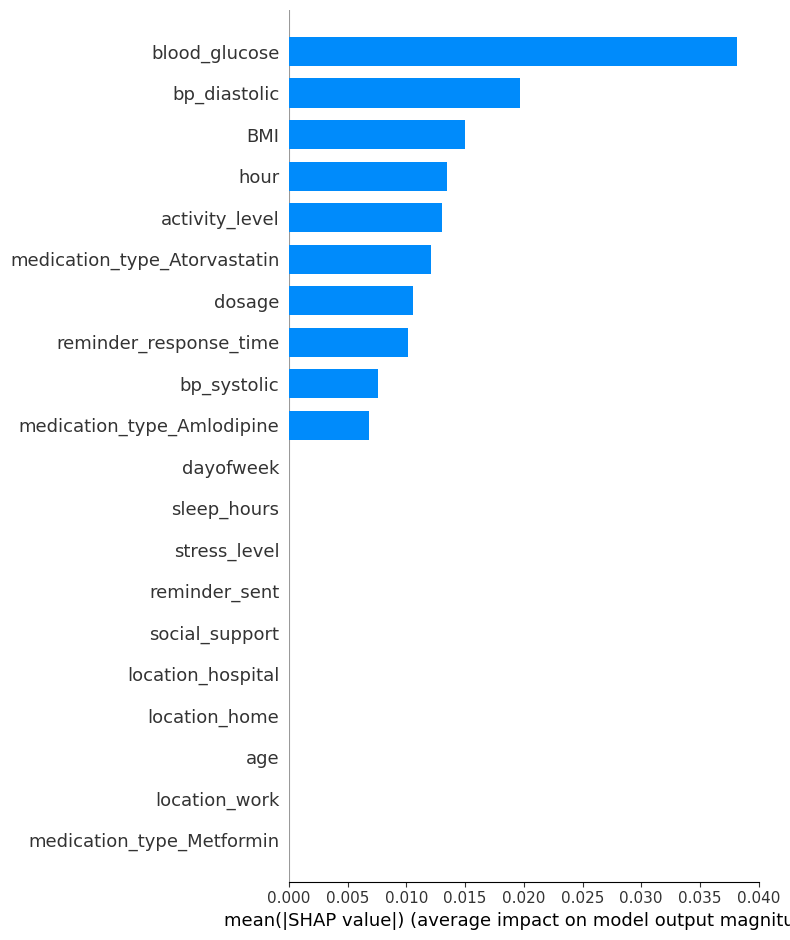

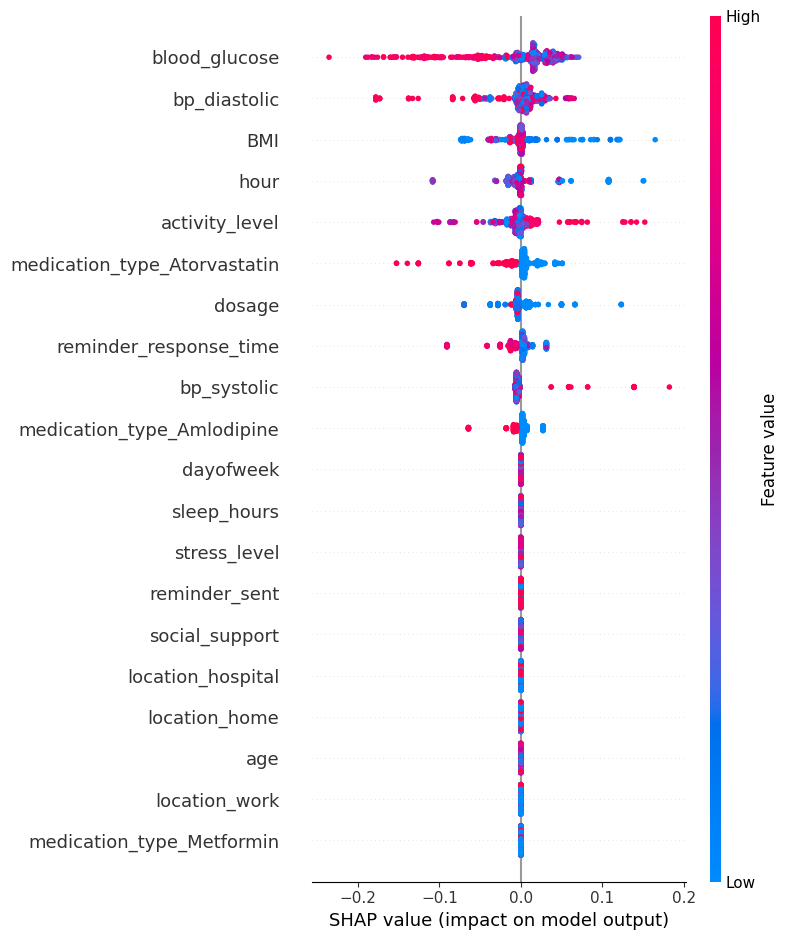

In [519]:
shap.summary_plot(
    shap_values_positive,
    X_shap_transformed,
    feature_names=feature_names,
    plot_type="bar"
)

shap.summary_plot(
    shap_values_positive,
    X_shap_transformed,
    feature_names=feature_names
)


# LIME — LOCAL EXPLAINABILITY (after SHAP)

In [520]:
# Pilih sampel individu (ubah idx sesuai kebutuhan)
idx = 100
x_instance = X_test.iloc[idx].values
print(f"Sample index for LIME: {idx}")

Sample index for LIME: 100


In [521]:
# LIME setup: install/import, wrappers, and explainer initialization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    from lime.lime_tabular import LimeTabularExplainer
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "lime"])
    from lime.lime_tabular import LimeTabularExplainer

# Helper: ensure 2D shape
def _ensure_2d(arr):
    arr = np.array(arr)
    if arr.ndim == 1:
        arr = arr.reshape(1, -1)
    return arr

# Robust predict_proba wrapper that accepts numpy arrays (encoded) and returns probabilities
def predict_proba_with_df(arr):
    A = _ensure_2d(arr)
    X_df = pd.DataFrame(A, columns=X_train.columns)
    
    # Decode categorical features back to original string values
    # LIME passes encoded numeric values, but pipeline expects original strings
    for col in _cat_cols:
        if col in X_df.columns:
            # Create reverse mapping: encoded_value -> original_string
            reverse_map = {idx: val for val, idx in _cat_encodings[col].items()}
            X_df[col] = X_df[col].map(reverse_map).fillna(X_df[col])
    
    model = final_pipeline
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X_df)
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X_df)
        scores = np.array(scores)
        if scores.ndim == 1:  # binary
            probs1 = 1.0 / (1.0 + np.exp(-scores))
            return np.column_stack([1 - probs1, probs1])
        else:  # multiclass softmax
            exps = np.exp(scores - np.max(scores, axis=1, keepdims=True))
            return exps / exps.sum(axis=1, keepdims=True)
    else:
        # Fallback (not ideal): convert hard predictions into pseudo-probabilities
        preds = model.predict(X_df)
        probs = np.full((len(preds), 2), 0.5, dtype=float)
        for i, p in enumerate(preds):
            if int(p) == 1:
                probs[i] = [0.1, 0.9]
            else:
                probs[i] = [0.9, 0.1]
        return probs

# Detect categorical columns - use the categorical_features defined earlier
if 'categorical_features' in globals() and categorical_features:
    _cat_cols = [c for c in categorical_features if c in X_train.columns]
else:
    _cat_cols = [c for c in X_train.columns if str(X_train[c].dtype) in ("object", "category")]

_categorical_features = [X_train.columns.get_loc(c) for c in _cat_cols]
_categorical_names = {
    X_train.columns.get_loc(c): sorted([str(v) for v in X_train[c].dropna().unique()]) 
    for c in _cat_cols
}

# Map class indices to human-friendly names in the order used by predict_proba
_classes_attr = None
if hasattr(final_pipeline, 'classes_'):
    _classes_attr = list(final_pipeline.classes_)
else:
    try:
        for _name, _step in getattr(final_pipeline, 'named_steps', {}).items():
            if hasattr(_step, 'classes_'):
                _classes_attr = list(_step.classes_)
                break
    except Exception:
        pass
if _classes_attr is None:
    _classes_attr = [0, 1]

_label_names = {0: 'Adherent (0)', 1: 'Non-Adherent (1)'}
_class_names = [_label_names.get(int(c), str(c)) for c in _classes_attr]

# Encode categorical features for LIME training data
X_train_lime = X_train.copy()
_cat_encodings = {}
for col in _cat_cols:
    unique_vals = sorted(X_train[col].dropna().unique())
    _cat_encodings[col] = {val: float(idx) for idx, val in enumerate(unique_vals)}
    # Ensure the mapping is applied correctly
    X_train_lime[col] = X_train[col].fillna('missing').map(_cat_encodings[col])
    # Any values that couldn't be mapped get -1
    X_train_lime[col] = X_train_lime[col].fillna(-1.0)

# Ensure all data is float
for col in X_train_lime.columns:
    if col in _cat_cols:
        X_train_lime[col] = X_train_lime[col].astype(float)
    elif X_train_lime[col].dtype == 'object':
        # Try to convert to float, otherwise use -1
        try:
            X_train_lime[col] = pd.to_numeric(X_train_lime[col], errors='coerce').fillna(-1.0)
        except:
            X_train_lime[col] = -1.0
    else:
        X_train_lime[col] = X_train_lime[col].astype(float)

print("Encoding check:", X_train_lime.dtypes)
print("Sample encoded row:", X_train_lime.iloc[0].values)

# Initialize LIME explainer on the encoded feature space
lime_explainer = LimeTabularExplainer(
    training_data=X_train_lime.values.astype(float),
    feature_names=list(X_train.columns),
    class_names=_class_names,
    categorical_features=_categorical_features if len(_categorical_features) > 0 else None,
    categorical_names=_categorical_names if len(_categorical_names) > 0 else None,
    discretize_continuous=True,
    mode='classification',
    random_state=42
)
print("LIME explainer is ready. Categorical features:", _cat_cols)

Encoding check: age                       float64
gender                    float64
chronic_condition         float64
medication_type           float64
dosage                    float64
comorbidities             float64
BMI                       float64
taken                     float64
missed_reason             float64
device_id                 float64
heart_rate                float64
blood_glucose             float64
activity_level            float64
sleep_hours               float64
stress_level              float64
reminder_sent             float64
reminder_response_time    float64
social_support            float64
location                  float64
hour                      float64
dayofweek                 float64
bp_systolic               float64
bp_diastolic              float64
dtype: object
Sample encoded row: [ 4.500e+01  1.000e+00  2.000e+00  2.000e+00  5.000e+01  0.000e+00
  2.480e+01  1.000e+00 -1.000e+00 -1.000e+00  7.000e+01  1.702e+02
  8.030e+03  5.200e+00  3.000e+00 

Predicted probabilities for the selected sample:
- Adherent (0): 0.4752
- Non-Adherent (1): 0.5248

LIME contributions toward Non-Adherent (1):


,Feature,Weight
0,126.05 < blood_glucose <= 152.70,0.031807
1,reminder_response_time > 78.00,-0.020679
2,device_id > -1.00,0.019565
3,medication_type=Amlodipine,-0.019374
4,hour <= 5.00,0.011545
5,75.00 < bp_diastolic <= 80.00,0.011113
6,10.00 < dosage <= 20.00,-0.007694
7,79.00 < heart_rate <= 90.00,-0.005492
8,age <= 45.00,0.005322
9,26.40 < BMI <= 30.60,-0.004928


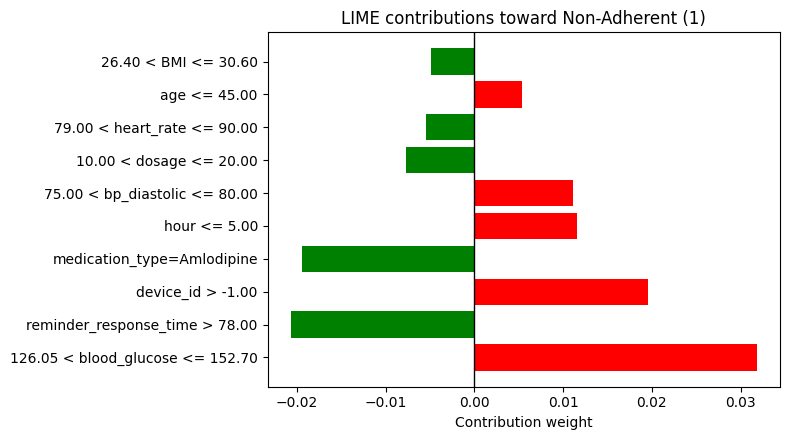


Predicted class: Non-Adherent (1)


In [522]:
# Run LIME explanation on the selected instance and visualize
# Encode categorical features in the instance
x_instance_lime = X_test.iloc[idx].copy()

# Encode ALL categorical columns (not just _cat_cols)
for col in X_train.columns:
    if X_train[col].dtype in ('object', 'category'):
        # This is a categorical column
        if col in _cat_encodings:
            val = x_instance_lime[col]
            x_instance_lime[col] = _cat_encodings[col].get(val, -1.0)
        else:
            # If not in encodings, encode on the fly
            unique_vals = sorted(X_train[col].dropna().unique())
            mapping = {v: float(i) for i, v in enumerate(unique_vals)}
            _cat_encodings[col] = mapping
            x_instance_lime[col] = mapping.get(x_instance_lime[col], -1.0)
    else:
        # Numeric column
        x_instance_lime[col] = float(x_instance_lime[col])

x_instance_encoded = x_instance_lime.values.astype(float)

# Explain for class 1 if available (Non-Adherent), else fallback to predicted class
exp = lime_explainer.explain_instance(
    data_row=x_instance_encoded,
    predict_fn=predict_proba_with_df,
    num_features=int(min(10, X_train.shape[1])),
    labels=_classes_attr if len(_classes_attr) == 2 else [_classes_attr[0]]
)

# Predicted probabilities for the selected instance
probs = predict_proba_with_df(x_instance)[0]
prob_map = {str(_label_names.get(int(c), str(c))): float(probs[i]) for i, c in enumerate(_classes_attr)}
print("Predicted probabilities for the selected sample:")
for cname in _class_names:
    print(f"- {cname}: {prob_map.get(cname, 'n/a'):.4f}")

# Choose target label for interpretation
if 1 in _classes_attr:
    target_label = 1
else:
    target_label = _classes_attr[int(np.argmax(probs))]

# Contributions toward the chosen label
contribs = exp.as_list(label=target_label)

# Display contributions as a table
import pandas as pd
contrib_df = pd.DataFrame(contribs, columns=["Feature", "Weight"])
print(f"\nLIME contributions toward {_label_names.get(int(target_label), str(target_label))}:")
display(contrib_df)

# Bar chart visualization
import matplotlib.pyplot as plt
features = [f for f, _ in contribs]
weights = np.array([w for _, w in contribs])

# Color logic: positive weight supports target_label
if int(target_label) == 1:
    colors = ['red' if w > 0 else 'green' for w in weights]
else:
    colors = ['green' if w > 0 else 'red' for w in weights]

plt.figure(figsize=(8, max(3, 0.45 * len(weights))))
y = np.arange(len(weights))
plt.barh(y, weights, color=colors)
plt.yticks(y, features)
plt.axvline(0, color='black', linewidth=1)
plt.title(f"LIME contributions toward {_label_names.get(int(target_label), str(target_label))}")
plt.xlabel("Contribution weight")
plt.tight_layout()
plt.show()

pred_class = _classes_attr[int(np.argmax(probs))]
print(f"\nPredicted class: {_label_names.get(int(pred_class), str(pred_class))}")

In [523]:
print("\n" + "="*80)
print("LIME ANALYSIS FOR 100 PATIENTS - BATCH PROCESSING")
print("="*80)

# ========== 1. BATCH LIME EXPLANATION ==========
import time
from tqdm import tqdm

# Pilih 100 sampel (bisa ubah range sesuai test set size)
sample_indices = np.random.choice(len(X_test), size=min(100, len(X_test)), replace=False)
sample_indices = sorted(sample_indices)

print(f"\n🔍 Processing LIME explanations for {len(sample_indices)} patients...")
print(f"   Patient indices: {sample_indices[:10]}... (showing first 10)")

# Store results
all_explanations = []
start_time = time.time()

for idx_sample in tqdm(sample_indices, desc="LIME Processing"):
    try:
        # Encode instance
        x_instance_lime = X_test.iloc[idx_sample].copy()
        
        for col in X_train.columns:
            if X_train[col].dtype in ('object', 'category'):
                if col in _cat_encodings:
                    val = x_instance_lime[col]
                    x_instance_lime[col] = _cat_encodings[col].get(val, -1.0)
                else:
                    unique_vals = sorted(X_train[col].dropna().unique())
                    mapping = {v: float(i) for i, v in enumerate(unique_vals)}
                    _cat_encodings[col] = mapping
                    x_instance_lime[col] = mapping.get(x_instance_lime[col], -1.0)
            else:
                x_instance_lime[col] = float(x_instance_lime[col])
        
        x_instance_encoded = x_instance_lime.values.astype(float)
        
        # Get LIME explanation
        exp = lime_explainer.explain_instance(
            data_row=x_instance_encoded,
            predict_fn=predict_proba_with_df,
            num_features=10,
            labels=[1]  # Non-Adherent class
        )
        
        # Extract contributions
        contribs = exp.as_list(label=1)
        probs = predict_proba_with_df(x_instance_encoded.reshape(1, -1))[0]
        pred_class = int(np.argmax(probs))
        
        # Store
        for feature, weight in contribs:
            all_explanations.append({
                'Patient_ID': idx_sample,
                'Feature': feature,
                'Weight': weight,
                'Prob_NonAdherent': probs[1],
                'Predicted_Class': pred_class,
                'Abs_Weight': abs(weight)
            })
    
    except Exception as e:
        print(f"   ⚠️ Error processing patient {idx_sample}: {str(e)}")
        continue

elapsed = time.time() - start_time
print(f"✅ Completed in {elapsed:.2f} seconds\n")

# Convert to DataFrame
lime_batch_df = pd.DataFrame(all_explanations)


LIME ANALYSIS FOR 100 PATIENTS - BATCH PROCESSING

🔍 Processing LIME explanations for 100 patients...
   Patient indices: [np.int32(2), np.int32(3), np.int32(7), np.int32(14), np.int32(23), np.int32(31), np.int32(33), np.int32(39), np.int32(42), np.int32(51)]... (showing first 10)


LIME Processing: 100%|██████████| 100/100 [00:23<00:00,  4.30it/s]

✅ Completed in 23.31 seconds



In [528]:
# ========== 2. AGGREGATE STATISTICS ==========
print("="*80)
print("AGGREGATE LIME STATISTICS (100 Patients)")
print("="*80)

# Average weight per feature across all patients
feature_avg_weight = lime_batch_df.groupby('Feature').agg({
    'Weight': ['mean', 'std', 'min', 'max', 'count'],
    'Abs_Weight': 'mean'
}).round(4)

feature_avg_weight.columns = ['Mean_Weight', 'Std_Weight', 'Min_Weight', 'Max_Weight', 'Frequency', 'Mean_Abs_Weight']
feature_avg_weight = feature_avg_weight.sort_values('Mean_Abs_Weight', ascending=False)

print("\n📊 Feature Contributions Across 100 Patients:")
print(feature_avg_weight.head(15))

AGGREGATE LIME STATISTICS (100 Patients)

📊 Feature Contributions Across 100 Patients:
                                     Mean_Weight  Std_Weight  Min_Weight  \
Feature                                                                    
blood_glucose > 152.70                   -0.0856      0.0041     -0.0948   
device_id > -1.00                        -0.0006      0.0562     -0.1702   
activity_level > 7661.25                  0.0324      0.0038      0.0229   
bp_diastolic > 84.00                     -0.0290      0.0045     -0.0372   
blood_glucose <= 98.47                    0.0289      0.0029      0.0248   
98.47 < blood_glucose <= 126.05           0.0288      0.0027      0.0235   
126.05 < blood_glucose <= 152.70          0.0280      0.0028      0.0206   
medication_type=Atorvastatin             -0.0277      0.0034     -0.0331   
dosage <= 10.00                           0.0252      0.0029      0.0177   
5.00 < hour <= 11.00                     -0.0232      0.0047     -0.0339   
5

C:\Users\User\AppData\Local\Temp\ipykernel_1184\888019626.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(data_for_box, labels=range(1, 11), vert=True)


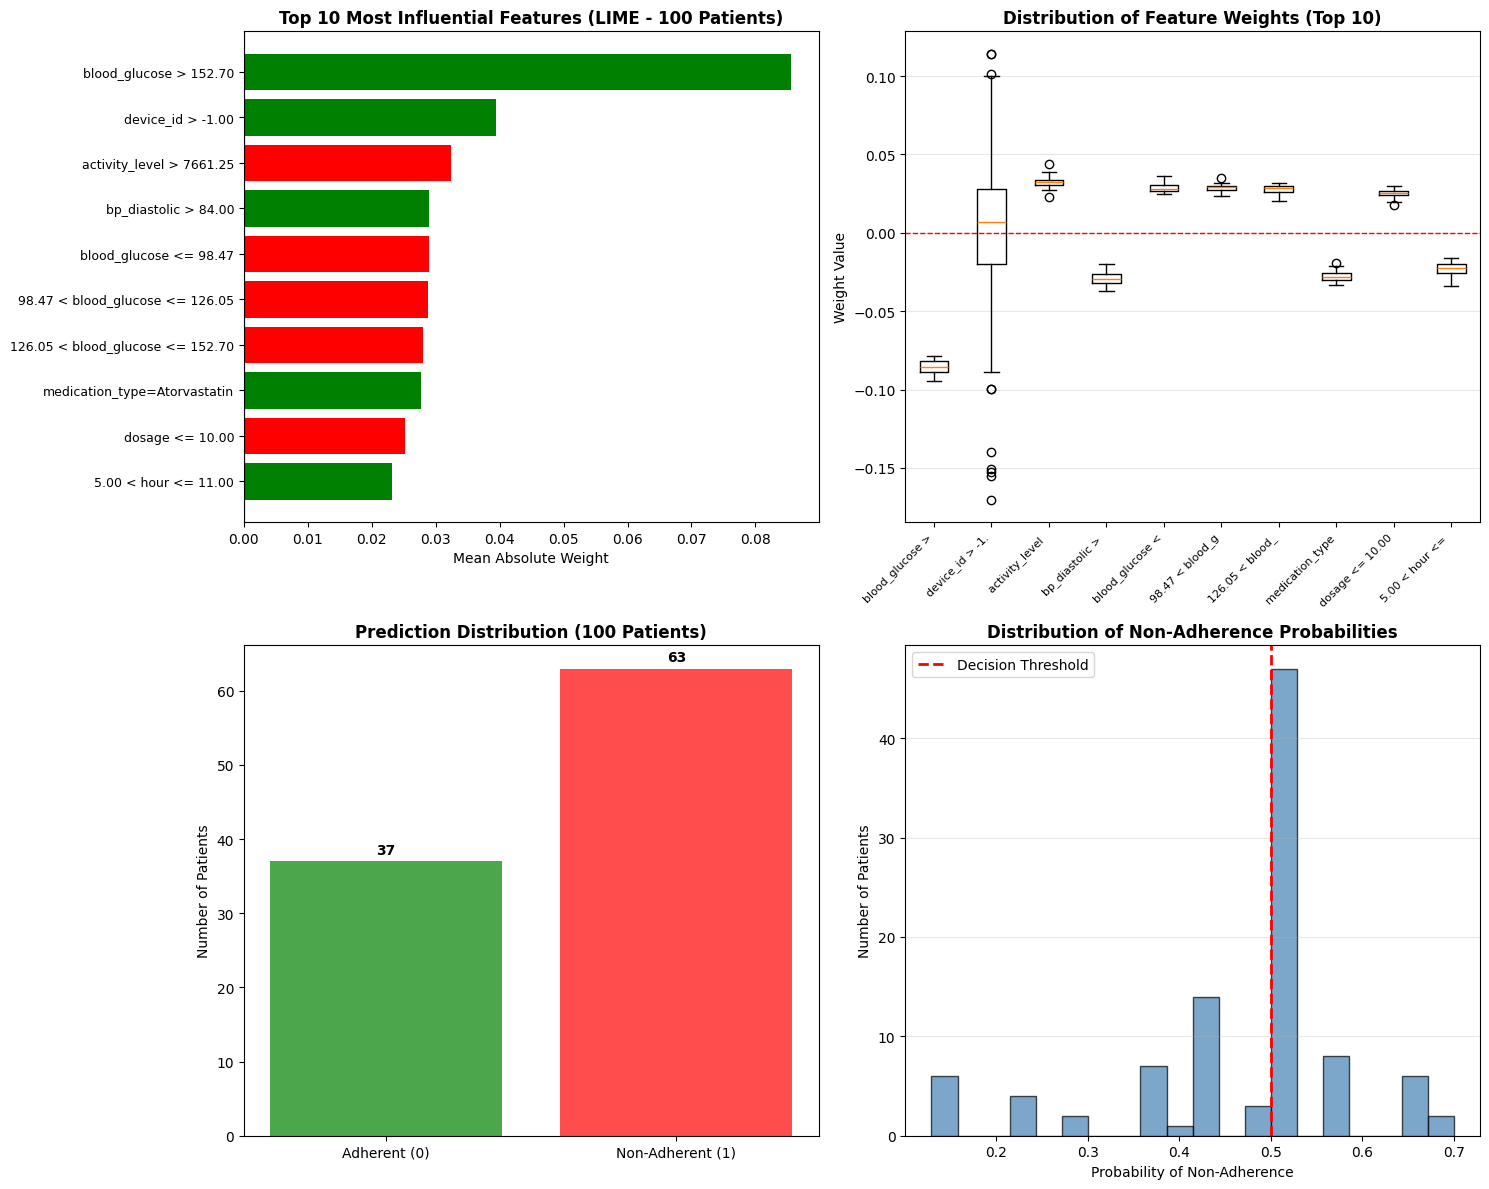


✅ Batch analysis plot saved as 'lime_batch_analysis.png'


In [529]:
# ========== 3. VISUALIZATIONS ==========

# 3A: Average Weight per Feature
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Mean Absolute Weight (Top 10)
ax1 = axes[0, 0]
top_features = feature_avg_weight.head(10).sort_values('Mean_Abs_Weight')
colors_plot = ['red' if x > 0 else 'green' for x in top_features['Mean_Weight']]
ax1.barh(range(len(top_features)), top_features['Mean_Abs_Weight'], color=colors_plot)
ax1.set_yticks(range(len(top_features)))
ax1.set_yticklabels(top_features.index, fontsize=9)
ax1.set_xlabel('Mean Absolute Weight')
ax1.set_title('Top 10 Most Influential Features (LIME - 100 Patients)', fontweight='bold')
ax1.axvline(0, color='black', linewidth=0.8)

# Plot 2: Weight Distribution by Feature (Box plot)
ax2 = axes[0, 1]
top_10_features = feature_avg_weight.head(10).index
data_for_box = [lime_batch_df[lime_batch_df['Feature'] == f]['Weight'].values for f in top_10_features]
bp = ax2.boxplot(data_for_box, labels=range(1, 11), vert=True)
ax2.set_xticklabels([f.split('<=|>|=')[0].strip()[:15] for f in top_10_features], rotation=45, ha='right', fontsize=8)
ax2.set_ylabel('Weight Value')
ax2.set_title('Distribution of Feature Weights (Top 10)', fontweight='bold')
ax2.axhline(0, color='red', linestyle='--', linewidth=1)
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Prediction Distribution
ax3 = axes[1, 0]
pred_dist = lime_batch_df.groupby('Predicted_Class')['Patient_ID'].nunique()
colors_pred = ['green', 'red']
ax3.bar(['Adherent (0)', 'Non-Adherent (1)'], [pred_dist.get(0, 0), pred_dist.get(1, 0)], color=colors_pred, alpha=0.7)
ax3.set_ylabel('Number of Patients')
ax3.set_title('Prediction Distribution (100 Patients)', fontweight='bold')
for i, v in enumerate([pred_dist.get(0, 0), pred_dist.get(1, 0)]):
    ax3.text(i, v + 1, str(v), ha='center', fontweight='bold')

# Plot 4: Probability Distribution
ax4 = axes[1, 1]
patient_probs = lime_batch_df.groupby('Patient_ID')['Prob_NonAdherent'].first()
ax4.hist(patient_probs, bins=20, color='steelblue', alpha=0.7, edgecolor='black')
ax4.axvline(0.5, color='red', linestyle='--', linewidth=2, label='Decision Threshold')
ax4.set_xlabel('Probability of Non-Adherence')
ax4.set_ylabel('Number of Patients')
ax4.set_title('Distribution of Non-Adherence Probabilities', fontweight='bold')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('lime_batch_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Batch analysis plot saved as 'lime_batch_analysis.png'")



In [530]:
# ========== 4. PATIENT SEGMENTATION BY LIME ==========
print("\n" + "="*80)
print("PATIENT SEGMENTATION ANALYSIS")
print("="*80)

# Create patient summary
patient_summary = lime_batch_df.groupby('Patient_ID').agg({
    'Prob_NonAdherent': 'first',
    'Predicted_Class': 'first',
    'Weight': lambda x: list(x)  # Store all weights
}).reset_index()

patient_summary['Top_Risk_Factor'] = lime_batch_df.groupby('Patient_ID').apply(
    lambda x: x.loc[x['Abs_Weight'].idxmax(), 'Feature']
).values

patient_summary['Top_Risk_Weight'] = lime_batch_df.groupby('Patient_ID').apply(
    lambda x: x.loc[x['Abs_Weight'].idxmax(), 'Weight']
).values

# Categorize patients
def categorize_risk(prob):
    if prob < 0.3:
        return 'Low Risk (Adherent)'
    elif prob < 0.5:
        return 'Moderate Risk (Borderline)'
    elif prob < 0.7:
        return 'High Risk (Borderline)'
    else:
        return 'Very High Risk (Non-Adherent)'

patient_summary['Risk_Category'] = patient_summary['Prob_NonAdherent'].apply(categorize_risk)

print("\n👥 Risk Category Distribution:")
risk_dist = patient_summary['Risk_Category'].value_counts()
for category, count in risk_dist.items():
    pct = (count / len(patient_summary)) * 100
    print(f"   {category:40} : {count:3} patients ({pct:5.1f}%)")



PATIENT SEGMENTATION ANALYSIS

👥 Risk Category Distribution:
   High Risk (Borderline)                   :  63 patients ( 63.0%)
   Moderate Risk (Borderline)               :  25 patients ( 25.0%)
   Low Risk (Adherent)                      :  12 patients ( 12.0%)


C:\Users\User\AppData\Local\Temp\ipykernel_1184\982192527.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_summary['Top_Risk_Factor'] = lime_batch_df.groupby('Patient_ID').apply(
C:\Users\User\AppData\Local\Temp\ipykernel_1184\982192527.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_summary['Top_Risk_Weight'] = lime_batch_df.groupby('Patient_ID').apply(


In [531]:
# ========== 5. TOP RISK FACTORS BY CATEGORY ==========
print("\n" + "="*80)
print("TOP RISK FACTORS BY RISK CATEGORY")
print("="*80)

for category in patient_summary['Risk_Category'].unique():
    patients_in_cat = patient_summary[patient_summary['Risk_Category'] == category]['Patient_ID'].values
    
    if len(patients_in_cat) > 0:
        lime_subset = lime_batch_df[lime_batch_df['Patient_ID'].isin(patients_in_cat)]
        top_factors = lime_subset.groupby('Feature')['Abs_Weight'].mean().sort_values(ascending=False).head(5)
        
        print(f"\n🎯 {category} (n={len(patients_in_cat)}):")
        for i, (feature, weight) in enumerate(top_factors.items(), 1):
            print(f"   {i}. {feature[:50]:50} (avg abs weight: {weight:.4f})")




TOP RISK FACTORS BY RISK CATEGORY

🎯 Moderate Risk (Borderline) (n=25):
   1. blood_glucose > 152.70                             (avg abs weight: 0.0866)
   2. activity_level > 7661.25                           (avg abs weight: 0.0320)
   3. 126.05 < blood_glucose <= 152.70                   (avg abs weight: 0.0315)
   4. blood_glucose <= 98.47                             (avg abs weight: 0.0291)
   5. bp_diastolic > 84.00                               (avg abs weight: 0.0285)

🎯 Low Risk (Adherent) (n=12):
   1. device_id > -1.00                                  (avg abs weight: 0.1085)
   2. blood_glucose > 152.70                             (avg abs weight: 0.0857)
   3. missed_reason > -1.00                              (avg abs weight: 0.0833)
   4. bp_diastolic > 84.00                               (avg abs weight: 0.0309)
   5. medication_type=Atorvastatin                       (avg abs weight: 0.0304)

🎯 High Risk (Borderline) (n=63):
   1. blood_glucose > 152.70              

In [532]:
# ========== 6. FEATURE CONSISTENCY ANALYSIS ==========
print("\n" + "="*80)
print("FEATURE CONSISTENCY & VARIABILITY")
print("="*80)

consistency_df = feature_avg_weight[['Mean_Weight', 'Std_Weight', 'Mean_Abs_Weight', 'Frequency']].copy()
consistency_df['Consistency_Score'] = 1 - (consistency_df['Std_Weight'] / (consistency_df['Mean_Abs_Weight'] + 0.001))
consistency_df = consistency_df.sort_values('Consistency_Score', ascending=False)

print("\n📈 Feature Consistency (1.0 = Consistent, <0 = Highly Variable):")
print(consistency_df[['Mean_Abs_Weight', 'Std_Weight', 'Consistency_Score']].head(10).round(4))



FEATURE CONSISTENCY & VARIABILITY

📈 Feature Consistency (1.0 = Consistent, <0 = Highly Variable):
                                  Mean_Abs_Weight  Std_Weight  \
Feature                                                         
blood_glucose > 152.70                     0.0856      0.0041   
5.28 < sleep_hours <= 6.50                 0.0064      0.0005   
location=work                              0.0047      0.0005   
98.47 < blood_glucose <= 126.05            0.0288      0.0027   
126.05 < blood_glucose <= 152.70           0.0280      0.0028   
blood_glucose <= 98.47                     0.0289      0.0029   
dosage <= 10.00                            0.0252      0.0029   
activity_level > 7661.25                   0.0324      0.0038   
medication_type=Metformin                  0.0187      0.0023   
medication_type=Atorvastatin               0.0277      0.0034   

                                  Consistency_Score  
Feature                                              
blood_gluco

In [533]:
# ========== 7. SUMMARY TABLE ==========
print("\n" + "="*80)
print("SUMMARY: KEY FINDINGS FROM 100 PATIENTS")
print("="*80)

summary_text = f"""
✅ LIME BATCH ANALYSIS SUMMARY:

1. SAMPLE SIZE: {len(sample_indices)} patients analyzed
   
2. PREDICTION DISTRIBUTION:
   • Adherent (0):      {pred_dist.get(0, 0):3} patients ({pred_dist.get(0, 0)/len(sample_indices)*100:5.1f}%)
   • Non-Adherent (1):  {pred_dist.get(1, 0):3} patients ({pred_dist.get(1, 0)/len(sample_indices)*100:5.1f}%)

3. TOP 5 INFLUENTIAL FEATURES:
"""

for i, (feature, row) in enumerate(feature_avg_weight.head(5).iterrows(), 1):
    direction = "↑ INCREASES" if row['Mean_Weight'] > 0 else "↓ DECREASES"
    summary_text += f"   {i}. {feature:50} {direction:15} non-adherence (weight: {row['Mean_Weight']:+.4f})\n"

summary_text += f"""
4. FEATURE VARIABILITY:
   • Most Consistent: {consistency_df.index[0]} (score: {consistency_df.iloc[0]['Consistency_Score']:.3f})
   • Most Variable:   {consistency_df.index[-1]} (score: {consistency_df.iloc[-1]['Consistency_Score']:.3f})

5. PROBABILITY STATISTICS:
   • Mean Non-Adherence Prob:  {patient_summary['Prob_NonAdherent'].mean():.4f}
   • Std Non-Adherence Prob:   {patient_summary['Prob_NonAdherent'].std():.4f}
   • Range: [{patient_summary['Prob_NonAdherent'].min():.4f}, {patient_summary['Prob_NonAdherent'].max():.4f}]

6. KEY INSIGHT:
   Features with HIGH mean weight and LOW std dev are most RELIABLE predictors
   across the patient population.
"""

print(summary_text)


SUMMARY: KEY FINDINGS FROM 100 PATIENTS

✅ LIME BATCH ANALYSIS SUMMARY:

1. SAMPLE SIZE: 100 patients analyzed

2. PREDICTION DISTRIBUTION:
   • Adherent (0):       37 patients ( 37.0%)
   • Non-Adherent (1):   63 patients ( 63.0%)

3. TOP 5 INFLUENTIAL FEATURES:
   1. blood_glucose > 152.70                             ↓ DECREASES     non-adherence (weight: -0.0856)
   2. device_id > -1.00                                  ↓ DECREASES     non-adherence (weight: -0.0006)
   3. activity_level > 7661.25                           ↑ INCREASES     non-adherence (weight: +0.0324)
   4. bp_diastolic > 84.00                               ↓ DECREASES     non-adherence (weight: -0.0290)
   5. blood_glucose <= 98.47                             ↑ INCREASES     non-adherence (weight: +0.0289)

4. FEATURE VARIABILITY:
   • Most Consistent: blood_glucose > 152.70 (score: 0.953)
   • Most Variable:   stress_level > 4.00 (score: nan)

5. PROBABILITY STATISTICS:
   • Mean Non-Adherence Prob:  0.4717
   •

In [536]:
# ========== 8. EXPORT RESULTS ==========
import os

print("\n" + "="*80)
print("EXPORTING DETAILED RESULTS")
print("="*80)

# Create output directory if it doesn't exist
output_dir = 'lime_analysis 100 patient'
os.makedirs(output_dir, exist_ok=True)

# Save detailed results
lime_batch_df.to_csv(os.path.join(output_dir, 'lime_100_patients_detailed.csv'), index=False)
patient_summary.to_csv(os.path.join(output_dir, 'lime_100_patients_summary.csv'), index=False)
feature_avg_weight.to_csv(os.path.join(output_dir, 'lime_feature_statistics.csv'))

# Update the plot save path in cell above
# Change this line in the visualization cell:
# plt.savefig('lime_batch_analysis.png', dpi=300, bbox_inches='tight')
# To:
# plt.savefig(os.path.join('lime_analysis', 'lime_batch_analysis.png'), dpi=300, bbox_inches='tight')

print(f"\n✅ Files saved to '{output_dir}/' folder:")
print(f"   • {output_dir}/lime_100_patients_detailed.csv")
print(f"   • {output_dir}/lime_100_patients_summary.csv")
print(f"   • {output_dir}/lime_feature_statistics.csv")
print(f"   • {output_dir}/lime_batch_analysis.png")

print(f"\n📂 Full path: {os.path.abspath(output_dir)}")


EXPORTING DETAILED RESULTS

✅ Files saved to 'lime_analysis 100 patient/' folder:
   • lime_analysis 100 patient/lime_100_patients_detailed.csv
   • lime_analysis 100 patient/lime_100_patients_summary.csv
   • lime_analysis 100 patient/lime_feature_statistics.csv
   • lime_analysis 100 patient/lime_batch_analysis.png

📂 Full path: d:\TESIS\Simulasi\Improving-Machine-Learning-Model-Performance-for-Patient-Non-Adherence-Prediction\lime_analysis 100 patient
